In [1]:
!pip install seaborn nltk wordcloud contractions

  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
import string
from string import punctuation
from tqdm import tqdm
from contractions import fix
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

[nltk_data] Downloading package punkt to C:\Users\himan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\himan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\himan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
!kaggle datasets download yasserh/twitter-tweets-sentiment-dataset

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!unzip twitter-tweets-sentiment-dataset.zip -d /content/

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
df = pd.read_csv('Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
df['text'].head()

0                  I`d have responded, if I were going
1        Sooo SAD I will miss you here in San Diego!!!
2                            my boss is bullying me...
3                       what interview! leave me alone
4     Sons of ****, why couldn`t they put them on t...
Name: text, dtype: object

In [7]:
#Let's drop selected text & text id column
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True) #Resetting the index
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [8]:
#Dimentions of the dataset
df.shape

(27481, 2)

In [9]:
#Checking the dtypes of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [10]:
#Descriptive summary of dataset
df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


In [11]:
#Checking Null values
df.isnull().sum()

text         1
sentiment    0
dtype: int64

 <p style="font-size:20px; font-family:verdana; line-height: 1.7em"> The dataset has one null row. So, we are dropping it</p>

In [12]:
#Dropping the null values
df.dropna(inplace=True)
df.describe()

,text,sentiment
count,27480,27480
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11117


In [13]:
#checking Duplicates
df.duplicated().sum()

0

<p style="font-size:20px; font-family:verdana; line-height: 1.7em"> No duplicates found</p>

<p style="font-size:24px; font-family:verdana; line-height: 1.7em">Let us visualize the sentiment words </p>

In [14]:
df[target].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

                 Sentiment Variable Distribution                  


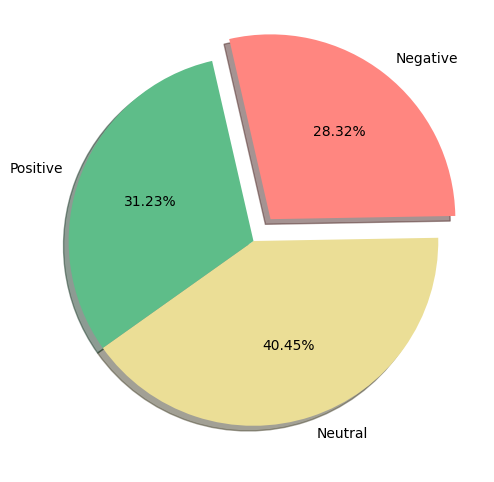

In [15]:
#Let's look at the overall distribution of positive, negative and neutral sentiments
print('\033[1mSentiment Variable Distribution'.center(70))
plt.figure(figsize=(12, 6))
colors = ['#ebde96', '#5ebd89', '#ff8680']
plt.pie(df[target].value_counts(), labels=['Neutral', 'Positive', 'Negative'], counterclock=False, shadow=True,
        explode=[0, 0, 0.15], autopct='%1.2f%%', radius=1, startangle=1, colors=colors)

plt.show()

<h3> visualizing wordcloud before preprocessing </h3>

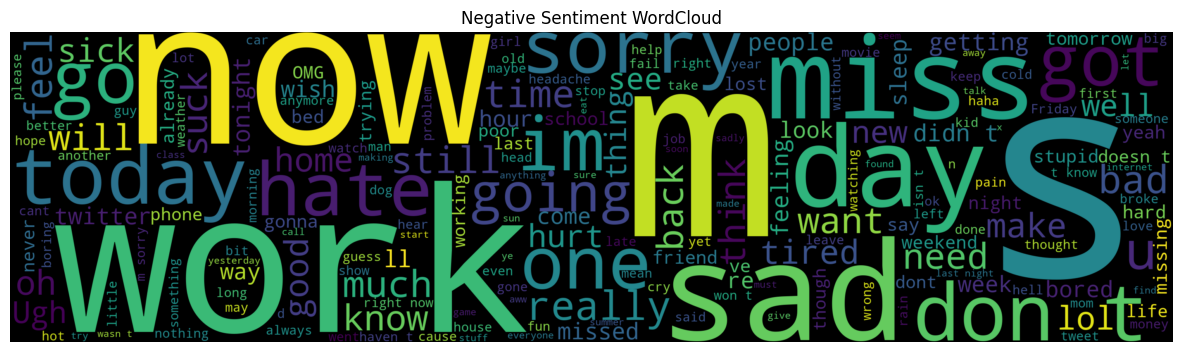

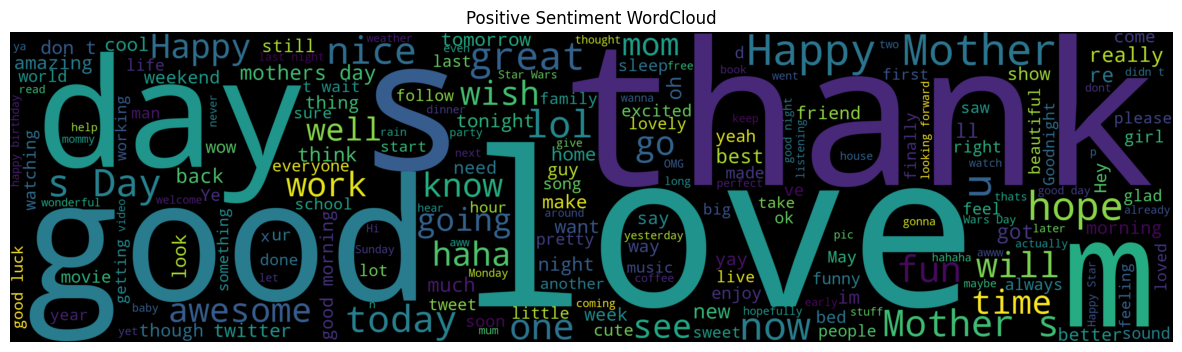

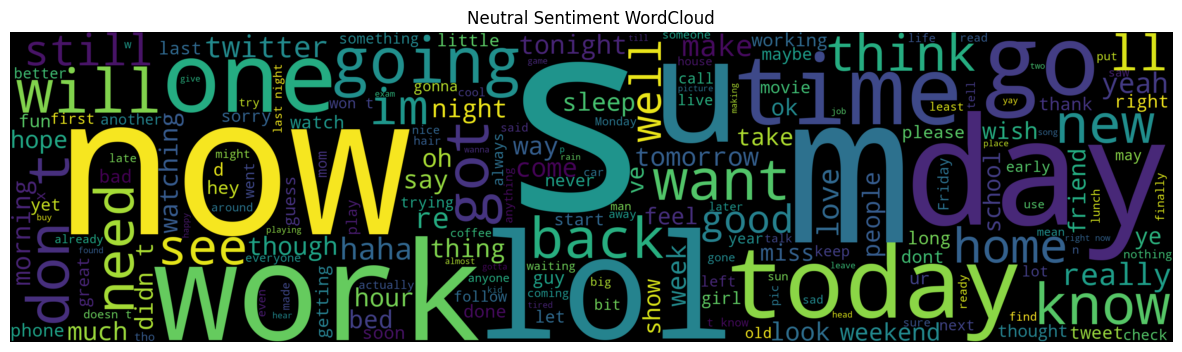

In [16]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black',
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')


##Data Preprocessing

In [17]:
essential_stopwords = [
    "not", "no", "never", "neither", "nor", "very", "so", "too", "much", "more", "most",
    "least", "extremely"
]


In [18]:
# Define a function to clean and preprocess the text
def preprocess_text(text):

    # Replace Backticks with apostrophes
    text = text.replace('`', "'")

    # Handling Negations
    text = fix(text) # Replace contractions like "don't" with "do not" for better sentiment context

    # Remove HTML tags and URLs
    text = re.sub(r'<.*?>|http\S+', '', text)

    # Remove digits and punctuations
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only alphabets and spaces

    # Convert text to lower case
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words - set(essential_stopwords)   # Remove essential stopwords from the standard list
    tokens = [word for word in tokens if word not in stop_words]

    # Perform Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back into a single string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply preprocessing function to text column
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [19]:
df.head()

,text,sentiment,cleaned_text
0,"I`d have responded, if I were going",neutral,would responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
2,my boss is bullying me...,negative,bos bullying
3,what interview! leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,son could not put release already bought


In [22]:
# Save the cleaned dataset
output_path = 'Tweets_cleaned.csv'
df.to_csv(output_path, index=False)